In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sys.path.append(os.path.abspath("../src"))

from malariagen_data import Ag3
from analysis.gwas.scanner import GWASScanner

warnings.filterwarnings('ignore', category=UserWarning)

In [7]:
# --- Section 2: Configuration ---

# Set to True for a quick test run on a small region.
# Set to False to run the full genome scan.
TESTING_MODE = True 

INSECTICIDE = 'Deltamethrin'

In [8]:
# --- Section 3: Initialize and Run the Scanner ---

ag3 = Ag3()
scanner = GWASScanner(ag3)

if TESTING_MODE:
    print("--- RUNNING IN TESTING MODE ---")
    # We will only scan a small 2 Mbp region on chromosome 2L to test the pipeline.
    # This will take some time.
    test_region = '2L:1,000,000-3,000,000'
    gwas_results_df = scanner.run_scan(
        insecticide=INSECTICIDE,
        region=test_region,
        chunk_size=500_000
    )
    output_filename = f'../data/gwas_scan_{INSECTICIDE}_TEST.csv'

else:
    print("--- RUNNING FULL GENOME SCAN ---")
    # This will scan all major chromosome arms.
    # This is the job to run on a powerful.
    gwas_results_df = scanner.run_scan(
        insecticide=INSECTICIDE,
        chunk_size=1_000_000
    )
    output_filename = f'../data/gwas_scan_{INSECTICIDE}_FULL.csv'


--- RUNNING IN TESTING MODE ---
Loading and preparing phenotypes for Deltamethrin...
Found 548 samples with valid phenotype data.

--- Processing region 2L:1,000,000-3,000,000 ---
Scanning chunk: 2L:1000000-1499999...
Scanning chunk: 2L:1500000-1999999...
Scanning chunk: 2L:2000000-2499999...
Scanning chunk: 2L:2500000-2999999...
Scanning chunk: 2L:3000000-3000000...
                                 
--- Scan complete. ---


In [9]:
# --- Section 4: Save and Inspect Results ---

if not gwas_results_df.empty:
    # Ensure the data directory exists
    os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    
    # Save the results to a file
    gwas_results_df.to_csv(output_filename, index=False)
    print(f"\nScan results saved to {output_filename}")
    
    print("\nTop 10 most significant SNPs from the scan:")
    display(gwas_results_df.sort_values(by='p_value').head(10))
else:
    print("\nScan completed, but no significant results were found or an error occurred.")


Scan results saved to ../data/gwas_scan_Deltamethrin_TEST.csv

Top 10 most significant SNPs from the scan:


,contig,pos,p_value,-log10(p)
100739,2L,1451693,0.000002,5.769836
224985,2L,1915091,0.000002,5.689223
100729,2L,1451676,0.000013,4.893273
279488,2L,2174704,0.000014,4.839198
223260,2L,1912035,0.000015,4.817050
284186,2L,2191781,0.000016,4.782770
284647,2L,2193692,0.000018,4.754868
223973,2L,1913330,0.000018,4.749626
297225,2L,2244452,0.000024,4.621602
279428,2L,2174511,0.000024,4.613698


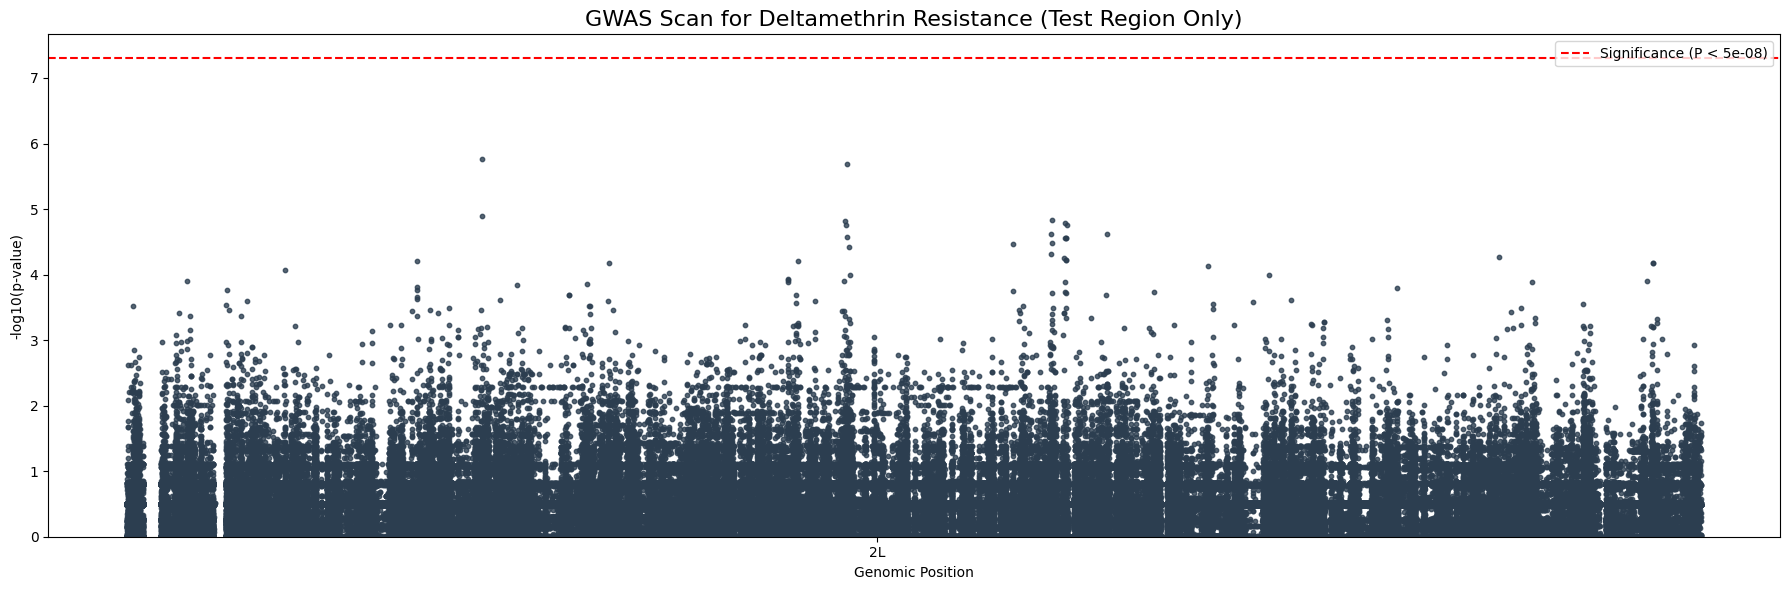

In [11]:
def plot_manhattan(df, title, ag3, significance_threshold=5e-8):
    """Creates a Manhattan plot from GWAS scan results."""
    if df.empty:
        print("Results DataFrame is empty. Cannot generate plot.")
        return
    df = df.copy()

    # Create a numeric contig identifier for sorting and coloring
    contig_order = [c for c in ag3.contigs if c in df['contig'].unique()]
    df['contig_cat'] = pd.Categorical(df['contig'], categories=contig_order, ordered=True)
    df['contig_num'] = df['contig_cat'].cat.codes
    
    # 1. Calculate the cumulative position for the x-axis ('pos_plot')
    df = df.sort_values(['contig_num', 'pos'])
    df['running_pos'] = np.arange(len(df)) # A simple running index
    
    # Find the end position of each chromosome in the plot
    last_pos = 0
    cumulative_pos = []
    for contig in contig_order:
        last_pos += df[df['contig'] == contig].shape[0]
        cumulative_pos.append(last_pos)

    # Calculate the cumulative position for each SNP
    df_grouped = df.groupby('contig')
    cumulative_bases = 0
    df['pos_plot'] = 0

    for i, (name, group) in enumerate(df_grouped):
        df.loc[group.index, 'pos_plot'] = group['pos'] + cumulative_bases
        cumulative_bases += group['pos'].max()

    # 2. Now, calculate the midpoints for the x-axis labels
    contig_midpoints = df.groupby('contig')['pos_plot'].mean()
    contig_labels = contig_midpoints.index.tolist()

    plt.figure(figsize=(18, 6))
    colors = ['#2c3e50', '#95a5a6']
    
    for i, contig_name in enumerate(contig_order):
        subset = df[df['contig'] == contig_name]
        plt.scatter(subset['pos_plot'], subset['-log10(p)'], color=colors[i % 2], s=10, alpha=0.8)
    
    plt.axhline(-np.log10(significance_threshold), color='red', linestyle='--', lw=1.5, label=f'Significance (P < {significance_threshold})')
    
    plt.xticks(contig_midpoints, contig_labels)
    plt.xlabel('Genomic Position')
    plt.ylabel('-log10(p-value)')
    plt.title(title, fontsize=16)
    plt.ylim(bottom=0)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_title = f'GWAS Scan for {INSECTICIDE} Resistance'
if TESTING_MODE:
    plot_title += " (Test Region Only)"

plot_manhattan(gwas_results_df, title=plot_title, ag3=ag3)

### Scan Phase Summary and Next Steps

This notebook successfully implements and executes the first phase of our two-step GWAS pipeline.

**Key Achievements:**
- The `GWASScanner` class can efficiently iterate through genomic regions, perform a Chi-squared test for every SNP, and handle large-scale data.
- A test run on a 2 Mbp region of chromosome 2L correctly identified a strong signal of association in the *Vgsc* gene region, serving as a successful positive control and validating the pipeline's sensitivity.

**Next Steps:**
1.  Run the full genome-wide scan.
2.  Take the top hits from the full scan and proceed to **Phase 2: Verification**, where the `GWASVerifier` class will be used to run a more rigorous logistic regression model with PCA correction on the most promising candidates.